# Introduction
- The predictions from the previous bigram model (counts, single linear layer) or are not good, because you just take one character of context
- you could take more chars into account, but the table would blow up exponentially e.g. one char: 27x27; two chars: 729x729

In this tutorial we implement a multilayer perceptron to predict the next character in a sequence (follows the paper Bengio et al. 2003)

In [56]:
# Start with 17.000 300-dim Embeddings (vocab: 17k big) random. Adjust them trough backprop.
# take the 3 previous words and predict the 4th word in a sentence
# lookup table e.g. 17kx30 (get embeddings by word index)
# input layer has 90 neurons, for 3 words x 30
# hidden layer size is a hyperparameter e.g. 100
# those are fully connected to the 90 input neurons
# output layer softmax. 17k neurons for every word (most computation is here - expensive layer)

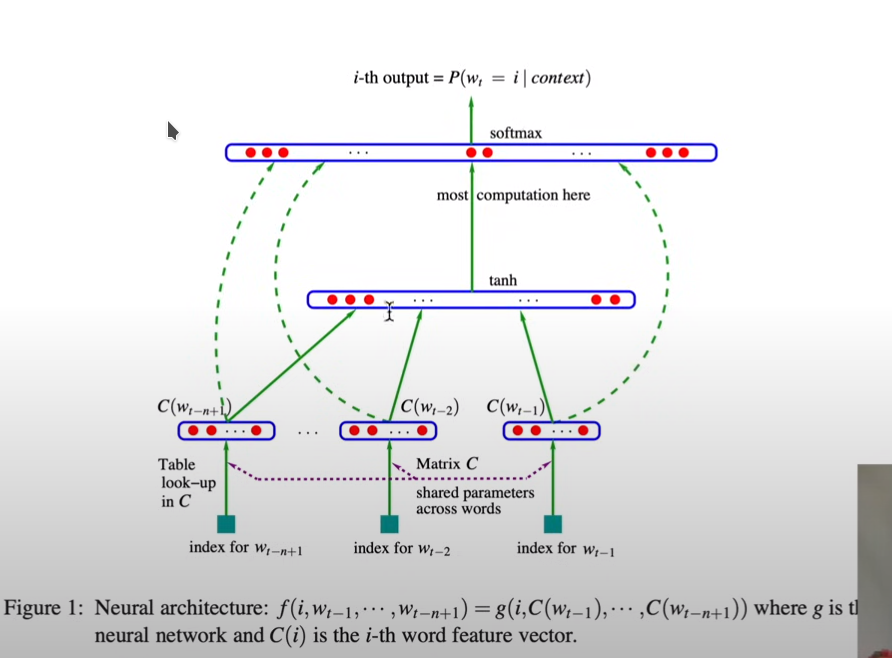

In [57]:
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
img = Image.open('imgs/02-mlp.png')
img

In [58]:
import torch
import torch.nn.functional as F
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [59]:
len(words)

32033

In [60]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [61]:
# build dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [62]:
X.shape, X.dtype, Y.shape, Y.dtype ## from the 5 words, we have created 32 examples, and each input in the NN is 3 integers

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [63]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [64]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [65]:
# embedding lookup table, example: 27x2
C = torch.randn((27, 2))
C

tensor([[-0.2590, -1.4507],
        [ 0.9199,  0.1426],
        [-0.5082, -0.0728],
        [ 0.0388,  0.3911],
        [-0.0205,  1.0818],
        [ 0.4699, -1.0463],
        [ 0.3693,  0.0469],
        [-0.5368, -1.3234],
        [ 1.6387,  0.3016],
        [-0.2626,  0.9964],
        [-0.0232,  0.2915],
        [-0.6078,  2.1800],
        [-0.8816, -0.8546],
        [-0.0053, -0.3878],
        [-0.4984,  1.2824],
        [ 0.9919,  2.9846],
        [-0.2341,  0.1481],
        [-0.0847,  0.4092],
        [-1.7118,  0.5813],
        [ 1.3129,  1.1418],
        [-2.1043,  0.3839],
        [ 1.1270, -2.0349],
        [-0.2453, -1.0409],
        [-1.8789,  0.0088],
        [-1.1638, -0.8681],
        [ 0.0546, -0.3899],
        [ 0.0728, -0.7959]])

In [66]:
## idential C[5] to:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # 1x27 x 27x2

tensor([ 0.4699, -1.0463])

In [67]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [68]:
W1 = torch.randn((6, 100)) # input to this layer (tanh) is 3x2 as we have 3 words with 2-dim embeddings. And the number of neurons is a variable. e.g. 100
b1 = torch.randn(100)

In [69]:
# now we would want to do that: emb @ W1 + b1
## but emb has the 3 dim indices. so we have to concatenate the 3 inputs (Ct, Ct-1, Ct-2) together
# we want: emb[:, 0, :].shape, emb[:, 1, :].shape, emb[:, 2, :].shape
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape #concatenate over dimension 1 (aka. 2; not over dim-0 which would be the 32)

torch.Size([32, 6])

In [70]:
# now that is hardcoded, for blocksize = 3 -> solution: make use of torch unbind:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [71]:
# but more efficient way: view()
# is much more efficient, because underlying a tensor, there is the storage: how its placed in memory
a = torch.arange(18)
a.shape


torch.Size([18])

In [72]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [73]:
## by changing view, it is still stored as this 1-dim vector in storage, but its "seen" (viewed) differently, by changing internal attributes like:
## storage offset, strides, shapes, ...
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [74]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # or -1
h

tensor([[ 0.9999, -1.0000, -1.0000,  ...,  0.9997, -0.9618, -0.3296],
        [ 0.9974, -0.9995, -1.0000,  ...,  0.9993, -0.9341, -0.4702],
        [ 0.9495, -0.9080, -0.9998,  ...,  0.9987, -0.9951,  0.2134],
        ...,
        [-1.0000,  0.6826,  0.9566,  ..., -1.0000,  0.9121,  0.5891],
        [-0.9998,  0.9998, -0.8066,  ..., -0.8718, -0.9992,  0.8015],
        [-0.9982,  0.6757,  0.9375,  ..., -0.8672,  0.9979,  0.9696]])

In [75]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [76]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [77]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape
prob[0].sum()

tensor(1.)

In [78]:
# so now, we like to index into the rows of prob and in each row, we like to plug out the prob. assigned to the correct character
prob[torch.arange(32), Y]

tensor([3.2849e-05, 1.9525e-02, 9.1228e-01, 4.2704e-10, 1.5737e-16, 1.3934e-04,
        1.8374e-08, 6.1022e-22, 6.2592e-11, 1.5726e-14, 1.8225e-06, 5.9047e-12,
        8.0984e-10, 1.1350e-09, 2.0027e-07, 2.4363e-13, 6.5134e-11, 1.8331e-08,
        7.1325e-05, 3.5081e-12, 1.5035e-08, 3.0109e-08, 2.8645e-08, 2.4641e-11,
        2.4698e-12, 3.4354e-03, 1.1738e-08, 1.4113e-05, 1.1874e-06, 5.7931e-01,
        2.7799e-04, 4.7902e-10])

In [79]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.3808)

In [92]:
## All together
# build dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [94]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [95]:
sum(p.nelement() for p in parameters)

3481

In [96]:
for p in parameters:
  p.requires_grad = True

In [98]:
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad

10.709587097167969
10.407632827758789
10.127808570861816
9.864365577697754
9.614503860473633
9.376440048217773
9.148944854736328
8.931111335754395
8.7222318649292
8.521749496459961
